## Inverter Model

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy import sin, cos,pi,zeros,sqrt
import pandas as pd

In [41]:
def dq0_abc_transform(v_d,v_q,v_0,omega,t_sol):
  wt = omega*np.array(t_sol)
  one = np.ones(len(wt))
  a = cos(wt)*v_d - sin(wt)*v_q + one*v_0
  b = cos(wt-2*pi/3)*v_d -sin(wt-2*pi/3)*v_q + one*v_0
  c = cos(wt+2*pi/3)*v_d -sin(wt+2*pi/3)*v_q + one*v_0
  return np.array([a,b,c])

In [42]:
Vdc = 800;
Kpc,Kic = 50,5000;
Rf = 0.07;
Lf = 5.2e-3;
Cf = 100e-6;
Lc = 1.5e-4;
Rc = 0.05;
w = 2*pi*50;
Kppll = 180;
Kipll = 3200;

In [43]:
def Inverter_Controller1(t,x):
    delta,ePLL,aPLL,ild,ilq,vod,voq,iod,ioq,zetad,zetaq = x
    #grid model   
    vbD,vbQ = 400*np.sqrt(2/3),0
    #ref setpoint
    ifdref,ifqref = 50, 0
    wgrid = 2*pi*50
    vbd,vbq = -np.sin(delta)*vbD + np.cos(delta)*vbQ, -np.cos(delta)*vbD - np.sin(delta)*vbQ
    #PLL Model
    ePLL_dot = (0-voq)
    w1 = Kppll*(0-voq) + Kipll*ePLL
    aPLL_dot = w1
    delta_dot = w1 - wgrid
    #current Controller
    zetad_dot = ifdref - ild
    zetaq_dot = ifqref - ilq
    vfdref = Kpc*(ifdref - ild) + Kic*zetad + vod - w1*Lf*ilq
    vfqref = Kpc*(ifqref - ilq) + Kic*zetaq + voq + w1*Lf*ild
    #Inverter Model
    vid,viq = np.array([vfdref,vfqref])
    #Filter Model
    ild_dot = (-Rf/Lf)*ild + w1*ilq + (vid - vod)/Lf
    ilq_dot = -w1*ild + (-Rf/Lf)*ilq + (viq - voq)/Lf
    vod_dot = w1*voq + (ild - iod)/Cf
    voq_dot = -w1*vod + (ilq - ioq)/Cf
    #Coupling Line
    iod_dot = (-Rc/Lc)*iod + w1*ioq + (vod - vbd)/Lc
    ioq_dot = -w1*iod + (-Rc/Lc)*ioq + (voq - vbq)/Lc

    return np.array([delta_dot,ePLL_dot,aPLL_dot,ild_dot,ilq_dot,vod_dot,voq_dot,iod_dot,ioq_dot,zetad_dot,zetaq_dot])


In [44]:
t0 = 0.0
t = 0.1
dt = 5e-6
t_eval = np.arange(t0,t,dt)
x0 = zeros(11)

In [45]:
In_sol0 = solve_ivp(Inverter_Controller1,[t0,t],y0 = x0,t_eval=t_eval)
t = In_sol0.t

In [46]:
deltas,ePLLs,aPLLs,ilds,ilqs,vods,voqs,iods,ioqs,zetads,zetaqs=In_sol0.y
tsim,iod,ioq,vod,voq,theta = pd.read_csv('I_data.csv').values

(0.0, 0.01)

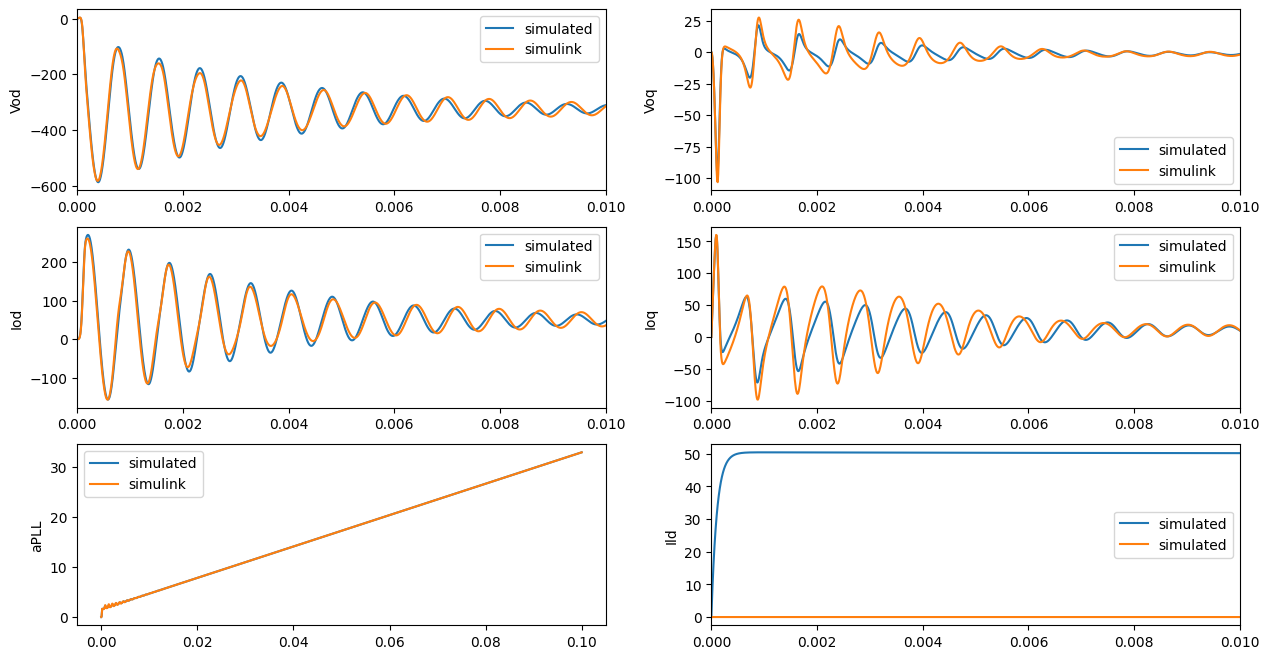

In [47]:
xlimit = [0,0.01]
fig, axs = plt.subplots(3, 2,figsize=(15,8))
axs[0, 0].plot(t_eval,vods,label = "simulated")
axs[0, 0].plot(tsim,vod,label="simulink")
axs[0, 0].set_xlim(xlimit)
axs[0, 0].set_ylabel("Vod")
axs[0, 0].legend()

axs[0, 1].plot(t_eval,voqs,label = "simulated")
axs[0, 1].plot(tsim,voq,label="simulink")
axs[0, 1].set_xlim(xlimit)
axs[0, 1].set_ylabel("Voq")
axs[0, 1].legend()

axs[1, 0].plot(t_eval,iods,label = "simulated")
axs[1, 0].plot(tsim,iod,label="simulink")
axs[1, 0].set_ylabel("Iod")
axs[1, 0].legend()
axs[1, 0].set_xlim(xlimit)

axs[1, 1].plot(t_eval,ioqs,label = "simulated")
axs[1, 1].plot(tsim,ioq,label="simulink")
axs[1, 1].set_ylabel("Ioq")
axs[1, 1].legend()
axs[1, 1].set_xlim(xlimit)

axs[2, 0].plot(t_eval, aPLLs,label = "simulated")
axs[2, 0].plot(tsim,theta,label="simulink")
axs[2, 0].set_ylabel("aPLL")
axs[2, 0].legend()
#axs[2, 0].set_xlim(xlimit)


axs[2, 1].plot(t_eval,ilds, label = "simulated")
axs[2, 1].plot(t_eval,ilqs, label = "simulated")
axs[2, 1].set_ylabel("Ild")
axs[2, 1].legend()
axs[2, 1].set_xlim(xlimit)

In [48]:
zeta.imag

NameError: name 'zeta' is not defined

In [695]:
~!@

SyntaxError: invalid syntax (798529566.py, line 1)

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy import sin, cos,pi,zeros,sqrt
import pandas as pd

In [68]:
Vdc = 800;
Kpc,Kic = 50,5000;
Rf = 0.07;
Lf = 5.2e-3;
Cf = 100e-6;
Lc = 1.5e-4;
Rc = 0.05;
w = 2*pi*50;
Kppll = 180;
Kipll = 3200;

In [75]:

def Inverter_Controller1(t,x):
    zetad,zetaq,ild,ilq,vod,voq,iod,ioq,ePLL,aPLL = x
    #PLL Model
    ePLL_dot = 0-voq
    dwPLL = Kppll*(0-voq) + Kipll*ePLL
    wPLL = dwPLL + w
    aPLL_dot = wPLL
    #ref transformation
    vgd = -400
    vgq = 0
    irefd = 100
    irefq = 0
    #current controller
    zetad_dot = irefd - ild
    vfrefd = Kpc*(irefd-ild) + Kic*zetad + vod - w*Lf*ilq
    zetaq_dot = irefq - ilq
    vfrefq = Kpc*(irefq-ilq) + Kic*zetaq + voq + w*Lf*ild
    #Inverter Model
    vid = vfrefd
    viq = vfrefq
    #filter
    ild_dot = (-Rf/Lf)*ild + w*ilq + (vid - vod)/Lf
    ilq_dot = -w*ild + (-Rf/Lf)*ilq + (viq - voq)/Lf
    vod_dot = w*voq + (ild - iod)/Cf
    voq_dot = -w*vod + (ilq - ioq)/Cf
    iod_dot = (-Rc/Lc)*iod + w*ioq + (vod - vgd)/Lc
    ioq_dot = -w*iod + (-Rc/Lc)*ioq + (voq - vgq)/Lc
        
    return np.array([zetad_dot,zetaq_dot,ild_dot,ilq_dot,vod_dot,voq_dot,iod_dot,ioq_dot,ePLL_dot,aPLL_dot])

In [76]:
t0 = 0.0
t = 0.1
dt = 0.000001
t_eval = np.arange(t0,t,dt)
x0 = zeros(10)

In [77]:
In_sol0 = solve_ivp(Inverter_Controller1,[t0,t],y0 = x0,t_eval=t_eval)
t = In_sol0.t

In [78]:
zetad,zetaq,ild,ilq,vod,voq,iod,ioq,ePLL,aPLL=In_sol0.y
tsim,iods,ioqs,vods,voqs,thetas = pd.read_csv('I_data.csv').values

(0.0, 0.03)

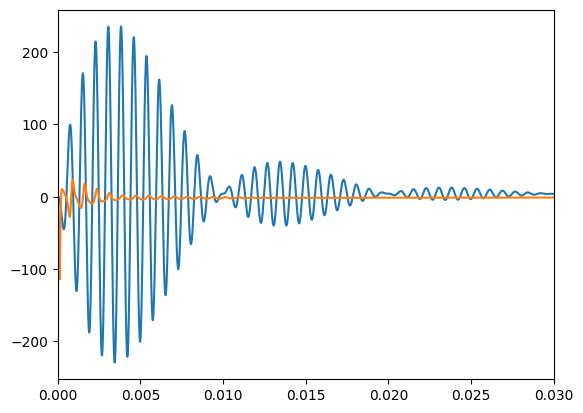

In [80]:
plt.plot(t_eval,voq)
plt.plot(tsim,voqs)
plt.xlim(0,0.03)